# Cloud Computing

### Part (i) Optimal energy consumption

In [12]:
using CSV, DataFrames, Plots, Statistics, StatsPlots, Distributions, Statistics, Gurobi, JuMP

In [26]:
capacity = CSV.read("HW2_data/capacity.csv", DataFrame)[:,2:end]
energy = CSV.read("HW2_data/energy.csv", DataFrame)[:,2:end]
energy = Matrix(energy)
maxutil = CSV.read("HW2_data/maxutil.csv", DataFrame)[:,2:end]
utilization = CSV.read("HW2_data/utilization.csv", DataFrame)[:,2:end]

println("Capacity: ", size(capacity))
println("Energy: ", size(energy))
println("Maxutil: ", size(maxutil))
println("Utilization: ", size(utilization))


Capacity: (20, 1)
Energy: (1000, 20)
Maxutil: (20, 1)
Utilization: (1000, 20)


In [27]:
model1 = Model(Gurobi.Optimizer)

n, m = size(energy)

# Define variables x[i,j] as the machine j activates for the job i 
@variable(model1, x[1:n, 1:m] >= 0)

# Define the objective function as the sum of energy consumption of all machines
@objective(model1, Min, sum(x[i,j] * energy[i,j] for i in 1:n, j in 1:m))

# Define the constraints that the total energy consumption of all machines should be less than the capacity
for j in 1:m
    @constraint(model1, sum(x[i,j] for i in 1:n) <= capacity[j,1])
end

# Define the constraints that each job should be assigned to one machine
for i in 1:n
    @constraint(model1, sum(x[i,j] for j in 1:m) == 1)
end


for i in 1:n
    for j in 1:m
        @constraint(model1, x[i,j]<=1)
    end
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-19


In [28]:
optimize!(model1)

println("Objective value: ", objective_value(model1))


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21020 rows, 20000 columns and 60000 nonzeros
Model fingerprint: 0xc095c4db
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 20000 rows and 0 columns
Presolve time: 0.02s
Presolved: 1020 rows, 20000 columns, 40000 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+04
 Factor NZ  : 2.168e+04 (roughly 9 MB of memory)
 Factor Ops : 4.729e+05 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.03 seconds (0.02 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Ite

### Part (ii) Energy consumption that would be achieved if each job could be assigned to any machine without any consideration for machine capacities

In [29]:
model2 = Model(Gurobi.Optimizer)

# Define variables y[i,j] as the machine j activates for the job i
@variable(model2, y[1:n, 1:m] >= 0)

# Define the objective function as the sum of energy consumption of all machines
@objective(model2, Min, sum(y[i,j] * energy[i,j] for i in 1:n, j in 1:m))

# Define the constraints that each job should be assigned to one machine
for i in 1:n
    @constraint(model2, sum(y[i,j] for j in 1:m) == 1)
end


for i in 1:n
    for j in 1:m
        @constraint(model2, y[i,j]<=1)
    end
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-19


In [30]:
optimize!(model2)

println("Objective value: ", objective_value(model2))

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21000 rows, 20000 columns and 40000 nonzeros
Model fingerprint: 0xca46c513
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 21000 rows and 20000 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0883161e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.01 work units)
Optimal objective  4.088316111e+04

User-callback calls 39, time in user-callback 0.00 sec
Objective value: 40883.161107001426


### Part (iii) Number of jobs that are not (fully) assigned to the machine with the lowest energy consumption.

In [39]:
jobs = 0

for i in 1:n
    index = argmin(energy[i,1:20])
    if value(x[i,index]) < 1
        jobs += 1
    end
end

println("Number of jobs that are not assigned to the machine with the lowest energy consumption: ", jobs)

Number of jobs that are not assigned to the machine with the lowest energy consumption: 386




### Part (i) Optimal energy consumption

In [32]:
model3 = Model(Gurobi.Optimizer)

# Define variables z[i,j] as the machine j activates for the job i
@variable(model3, z[1:n, 1:m] >= 0)

# Define the objective function as the sum of energy consumption of all machines
@objective(model3, Min, sum(z[i,j] * energy[i,j] for i in 1:n, j in 1:m))

# Define the constraints that each job should be assigned to one machine
for i in 1:n
    @constraint(model3, sum(z[i,j] for j in 1:m) == 1)
end

# Additional constraint: z[i,j] must be <= 1
for i in 1:n
    for j in 1:m
        @constraint(model3, z[i,j] <= 1)
    end
end

# Create a dictionary to store the utilization constraints
utilization_constraints = Dict{Int, ConstraintRef}()

# Define the utilization constraints and store them in the dictionary
for j in 1:m
    utilization_constraints[j] = @constraint(model3, sum(z[i,j] * utilization[i,j] for i in 1:n) <= maxutil[j,1])
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-19


In [33]:
optimize!(model3)

println("Objective value: ", objective_value(model3))

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21020 rows, 20000 columns and 60000 nonzeros
Model fingerprint: 0x21d9df14
Coefficient statistics:
  Matrix range     [1e+00, 9e+02]
  Objective range  [7e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 20000 rows and 0 columns
Presolve time: 0.02s
Presolved: 1020 rows, 20000 columns, 40000 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+04
 Factor NZ  : 2.168e+04 (roughly 9 MB of memory)
 Factor Ops : 4.729e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.27490183e+06  0.000000

### Part (ii) Energy consumption that would be achieved if each job could be assigned to any machine without any consideration for machine utilization

In [34]:
model4 = Model(Gurobi.Optimizer)

# Define variables y[i,j] as the machine j activates for the job i
@variable(model4, a[1:n, 1:m] >= 0)

# Define the objective function as the sum of energy consumption of all machines
@objective(model4, Min, sum(a[i,j] * energy[i,j] for i in 1:n, j in 1:m))

# Define the constraints that each job should be assigned to one machine
for i in 1:n
    @constraint(model4, sum(a[i,j] for j in 1:m) == 1)
end


for i in 1:n
    for j in 1:m
        @constraint(model4, a[i,j]<=1)
    end
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-19


In [35]:
optimize!(model4)

println("Objective value: ", objective_value(model4))

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21000 rows, 20000 columns and 40000 nonzeros
Model fingerprint: 0xca46c513
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 21000 rows and 20000 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0883161e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.01 work units)
Optimal objective  4.088316111e+04

User-callback calls 39, time in user-callback 0.00 sec
Objective value: 40883.161107001426


### Part (iii) Number of jobs that are not (fully) assigned to the machine with the lowest energy consumption.

In [38]:
jobs = 0

for i in 1:n
    index = argmin(energy[i,1:20])
    if value(z[i,index]) < 1
        jobs += 1
    end
end

println("Number of jobs that are not assigned to the machine with the lowest energy consumption: ", jobs)

Number of jobs that are not assigned to the machine with the lowest energy consumption: 885


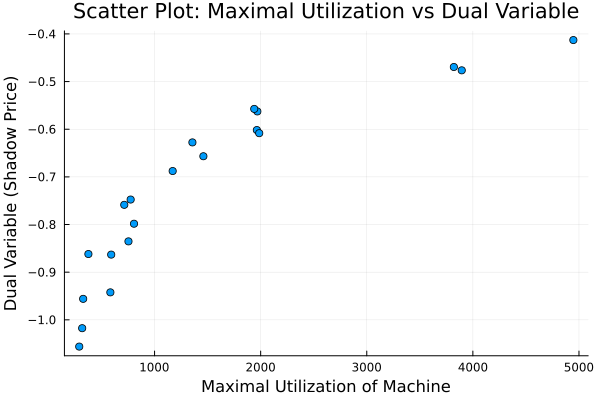

In [40]:
max_utilization = [sum(value.(z)[i,j] * utilization[i,j] for i in 1:n) for j in 1:m]

# Extract the dual variables (shadow prices) corresponding to the machine utilization constraints
dual_vars = [dual(utilization_constraints[j]) for j in 1:m]  

# Now, create the scatter plot
scatter(max_utilization, dual_vars,
    xlabel = "Maximal Utilization of Machine",
    ylabel = "Dual Variable (Shadow Price)",
    title = "Scatter Plot: Maximal Utilization vs Dual Variable",
    legend = false)